# Baseline Model

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
# import statsmodels.api as sm

import pickle
import csv
import re
import time

%matplotlib inline

np.random.seed(42)

## Load Cleaned Training Data

In [3]:
train_clean = pd.read_csv('../data/train_clean.csv', index_col='id',na_values='', keep_default_na=False)

In [4]:
train_clean.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,...,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,mo_sold,yr_sold,sale_type,saleprice
id,,,,,,,,,,,,,,,,,,,,,
109,60,RL,69.0552,13517,Pave,NA,IR1,Lvl,AllPub,CulDSac,...,0,0,0,NA,NA,NA,3,2010,WD,130500
544,60,RL,43.0000,11492,Pave,NA,IR1,Lvl,AllPub,CulDSac,...,0,0,0,NA,NA,NA,4,2009,WD,220000
153,20,RL,68.0000,7922,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,0,NA,NA,NA,1,2010,WD,109000
318,60,RL,73.0000,9802,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,0,0,NA,NA,NA,4,2010,WD,174000
255,50,RL,82.0000,14235,Pave,NA,IR1,Lvl,AllPub,Inside,...,0,0,0,NA,NA,NA,3,2010,WD,138500


## Confirming No Null Values

In [5]:
train_clean.isnull().sum().sum()

0

## Create Dummy Variables

We'll create dummy variables for all the categorical variables in the data set

This is also referred to as one hot encoding. It means that a categorical feature with k levels will result in k new features, each taking on the value of 0 or 1 to denote the presensce of that attribute.

This is essential to the modeling process, as most machine learning algorithms require data to be represented numerically.

In [6]:
train_clean_dummies = pd.get_dummies(train_clean)

We can check the shape and the head of the resulting dataset

In [7]:
train_clean_dummies.shape

(2051, 299)

The new dataframe now has 299 features

In [8]:
train_clean_dummies.head()

,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,...,misc_feature_Shed,sale_type_COD,sale_type_CWD,sale_type_Con,sale_type_ConLD,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_WD
id,,,,,,,,,,,,,,,,,,,,,
109,60,69.0552,13517,6,8,1976,2005,289.0,533.0,0.0,...,0,0,0,0,0,0,0,0,0,1
544,60,43.0000,11492,7,5,1996,1997,132.0,637.0,0.0,...,0,0,0,0,0,0,0,0,0,1
153,20,68.0000,7922,5,7,1953,2007,0.0,731.0,0.0,...,0,0,0,0,0,0,0,0,0,1
318,60,73.0000,9802,5,5,2006,2007,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
255,50,82.0000,14235,6,8,1900,1993,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


## Set up `X` and `y`

Next we'll create a dataframe with all our predictor variables and a series of the dependent variable (sale price)

Here we explicitly specify the response feature or dependent variable (sale price) and the dependent variables

In [9]:
X = train_clean_dummies.drop('saleprice', 1)
y = train_clean_dummies.saleprice

## Create training and validation sets

Next we'll use `train_test_split` to create a train and test set for our data. We'll train our model on the training data and test our fitted model on the test date to measure our accuracy. By default, we'll fit our model on 75% of the observations (training data) and use the remaining 25% to generate our predictions.

This holdout step is essentially to assessing the quality of our model. We want to fit a model that can be generalized and used to make accurate predictions on unseen data.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42)

## Apply Variance Threshold to remove low variance features

We'll apply a variance threshold, we'll calculate the variance of each feature and remove those with a variance below 0.05. The idea is that features with low variance contain less useful information and should be removed from the model. An example of this might be a categorical feature where 99% of the observations take on the same value.

In [24]:
threshold = VarianceThreshold(.05)

X_train_thresh = threshold.fit_transform(X_train)

X_test_thresh = threshold.transform(X_test)

## Get Columns from Data

In [11]:
columns = X.columns[threshold.get_support()]

In [12]:
columns

Index(['ms_subclass', 'lot_frontage', 'lot_area', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'mas_vnr_area',
       'bsmtfin_sf_1', 'bsmtfin_sf_2',
       ...
       'garage_qual_NA', 'garage_qual_TA', 'garage_cond_NA', 'garage_cond_TA',
       'paved_drive_N', 'paved_drive_Y', 'fence_MnPrv', 'fence_NA',
       'sale_type_New', 'sale_type_WD '],
      dtype='object', length=126)

Saving columns for kaggle data submission

In [38]:
len(columns)

127

## Scale the data

Scaling the data means that we will transform the data so that each feature will have a mean of 0 and a standard deviation of 1.

By scaling or standardizing our features we put all of our features on the same scale. Without scaling, features with greater magnitude (i.e. Living Area which is in the thousands) would be weighted more heavily than features of smaller magitude, like the number of bedrooms in a home.

We fit our scaler on the training data, which is then applied to the test data as well.

In [25]:
# instantiate StandardCaler
ss = StandardScaler()
ss.fit(X_train_thresh)
X_train_ss = ss.transform(X_train_thresh)
X_test_ss = ss.transform(X_test_thresh)

## Writing a quick function that allows me to enter a description of files as a I write them out

In [14]:
def filename_format_log(file_path, logfile='../file_log.txt', now=round(time.time()), file_description=None):
    try:
        ext = re.search('(?<!^)(?<!\.)\.(?!\.)', file_path).start()
    except:
        raise NameError('Please enter a relative path with a file extension.') 
    formatted_name = f'{file_path[:ext]}_{now}{file_path[ext:]}' 
    if not file_description:
        file_description = input('Please provide a brief description: ')
    with open(logfile, 'a+') as f:
        f.write(f'{formatted_name}: {file_description}\n')
    return formatted_name, now, file_description

## Export my data and scaler for use in future notebooks
Here I use my `filename_format_log` function to format all my filenames.

The first time I run this, I will capture all my outputs.

In [34]:
formatted_name, now, file_description = filename_format_log('../data/X_train_ss.csv')

with open(formatted_name, 'w+') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerows(X_train_ss)

Please provide a brief description:  Scaled training data


In [16]:
formatted_name, _, _= filename_format_log('../data/X_test_ss.csv', now=now, file_description=file_description)

with open(formatted_name, 'w+') as f:
    csv_writer = csv.writer(f)
    csv_writer.writerows(X_test_ss)

In [17]:
formatted_name, _, _= filename_format_log('../data/y_train.csv', now=now, file_description=file_description)

y_train.to_csv(formatted_name, index=False, header=False)

In [18]:
formatted_name, _, _= filename_format_log('../data/y_test.csv', now=now, file_description=file_description)

y_test.to_csv(formatted_name, index=False, header=False)

Pickle the Scaler

In [19]:
formatted_name, _, _= filename_format_log('../assets/scaler.pkl', now=now, file_description=file_description)

with open(formatted_name, 'wb+') as f:
    pickle.dump(ss, f)

## I'll also save out my column labels to make sure that I can line up my data properly

In [20]:
formatted_name, _, _= filename_format_log('../assets/columns.pkl', now=now, file_description=file_description)

with open(formatted_name, 'wb+') as f:
    pickle.dump(columns, f)

## Now I can use pattern matching to find all of my files created at this time

In [21]:
!ls ../*/*'{now}'*

../assets/columns_1553494338.pkl  ../data/X_train_ss_1553494338.csv
../assets/scaler_1553494338.pkl   ../data/y_test_1553494338.csv
../data/X_test_ss_1553494338.csv  ../data/y_train_1553494338.csv


In [22]:
file_list = !ls ../*/*'{now}'*

In [23]:
file_list

['../assets/columns_1553494338.pkl',
 '../assets/scaler_1553494338.pkl',
 '../data/X_test_ss_1553494338.csv',
 '../data/X_train_ss_1553494338.csv',
 '../data/y_test_1553494338.csv',
 '../data/y_train_1553494338.csv']

This custom function will extract the element name back from the filepath.

In [24]:
def extract_element_name(file_path, now):
    return re.findall(f'/([^/]*)_{now}', file_path)[0]

Paired with this function, we'll have all our elements in a neat dictionary.

In [25]:
def make_file_dict(now):
    file_dict = {}
    file_list = !ls ../*/*'{now}'*
    for file in file_list:
        file_dict[extract_element_name(file, now)] = file
    return file_dict

In [26]:
file_dict = make_file_dict(now)

In [27]:
file_dict

{'columns': '../assets/columns_1553494338.pkl',
 'scaler': '../assets/scaler_1553494338.pkl',
 'X_test_ss': '../data/X_test_ss_1553494338.csv',
 'X_train_ss': '../data/X_train_ss_1553494338.csv',
 'y_test': '../data/y_test_1553494338.csv',
 'y_train': '../data/y_train_1553494338.csv'}

## Assessing the RMSE of our Naive Model

It's helpful to create a benchmark to compare our model performance against. In the case of predicting sale prices, the simplist prediction would just be to assume the mean sale price for each home. This would be our Naive model. Using this approach we can measure avg. error in our predictions by calculating the RMSE or root mean square error. The goal of linear regression is to define a function to minimize this error.

Below we can calculate the RMSE of the Naive model for our test data:

In [20]:
round(((((y_test - y_test.mean())**2).sum()/len(y_test)))**0.5,0)

78358.0

Here we see the RMSE of our Naive model is 78K. That means that by just predicting the mean for each observation, our predictions would differ from the true sale price by 78K on avg.

Any model we produce should result in a lower RMSE

## Fitting the Linear Regression Model

Instantiate the model:

In [26]:
lr = LinearRegression()

Fit the model to the scaled training data

In [27]:
lr.fit(X_train_ss, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Below we can calculate the R2 score on our training data. This is a measure between 0 - 1; a 0 would mean that our model explains 0% of the variation in the sales price

In [28]:
lr.score(X_train_ss, y_train)

0.8806170520392764

The R2 score of 88% tells us our model explains 88% of the variation in the sale price. However, we are more concerned with how our model performs on the unseen test data, rather than the data that was used to fit the model.

In [29]:
lr.score(X_test_ss, y_test)

0.9004043358044791

The test R2 score increased to 90%. This is quite unlikely, as the score will usually decrease on test data

Next we can calculate the y-intercept of our model. This represents the base sales price, or the starting price

In [30]:
lr.intercept_

181062.5089997773

The base sales price is $18K

Below we can see the coefficients from our loss function. Positive coefficients indicate a positive relationship to the response, while negative coefficients have a negative relationship with the response.

In [31]:
lr.coef_

array([ 4.70083169e+01, -2.12887475e+03,  3.61695827e+03,  1.45527411e+04,
        4.86029825e+03,  5.65765788e+03,  1.64689367e+03,  4.24700756e+03,
       -2.81006273e+15, -1.01849698e+15, -2.65787258e+15,  2.72541257e+15,
        5.70659183e+14,  6.00961080e+14,  7.45540693e+13, -7.16068799e+14,
        6.17512500e+03,  2.29687500e+00,  4.40242188e+03,  1.67243750e+03,
        3.93906250e+01,  2.62959375e+03,  2.12016406e+03, -8.38000000e+02,
        8.40137500e+03,  3.08687500e+02,  1.33018750e+03, -1.09046875e+03,
        1.20343750e+03,  1.54159375e+03,  5.49407812e+03, -3.62721875e+03,
        7.18046875e+01, -5.19460938e+02,  1.61431250e+03,  4.22956250e+03,
        1.00896875e+03,  1.01250000e+03,  1.20846875e+03,  2.04187500e+02,
        4.22500000e+02,  1.71468750e+03,  3.18550000e+03,  2.19418750e+03,
       -2.77734375e+03, -5.41284375e+03, -4.14890625e+03, -2.72112500e+03,
        4.67621875e+03, -2.35837500e+03, -1.67729688e+03,  1.77812500e+03,
        2.82021094e+03,  

Next we can calculate the RSME of our linear regression model

In [32]:
(((y_test - lr.predict(X_test_ss))**2).sum()/len(lr.predict(X_test_ss)))**0.5

24728.927214746705

The RMSE dropped to 24.7K, a huge improvement from the 78K produced from our Naive model

## Import my columns list so that I can align it with values for inference

We can import our column names we saved earlier. We'll create a data frame of our coefficients, and we'll set the column names as our index.

In [39]:
with open('../assets/columns_1553494338.pkl', 'rb') as f:
    columns = pickle.load(f)

In [40]:
betas = pd.DataFrame(lr.coef_, index=columns)

In [41]:
betas.head()

,0
ms_subclass,47.008317
lot_frontage,-2128.874745
lot_area,3616.958267
overall_qual,14552.741053
overall_cond,4860.298248


We'll lable our column of coefficients as 'weights', and we'll create a new column which is the absolute value of our weights in order to compare the overall magnitude, regardless of direction

In [42]:
betas.columns = ['weights']
betas['abs_w'] = betas['weights'].abs()
betas.head()

,weights,abs_w
ms_subclass,47.008317,47.008317
lot_frontage,-2128.874745,2128.874745
lot_area,3616.958267,3616.958267
overall_qual,14552.741053,14552.741053
overall_cond,4860.298248,4860.298248


We can examine the top 10 most impactful variables in our model, or variables with the highest coefficients

In [50]:
weights = betas.sort_values('abs_w', ascending=False)['weights'].head(10)

In [51]:
weights

garage_finish_Unf   -5.876071e+15
garage_finish_RFn   -5.404814e+15
garage_finish_Fin   -5.132883e+15
bsmtfin_sf_1        -2.810063e+15
total_bsmt_sf        2.725413e+15
bsmt_unf_sf         -2.657873e+15
central_air_Y       -2.560596e+15
central_air_N       -2.560596e+15
garage_qual_NA      -1.440993e+15
garage_finish_NA    -1.440993e+15
Name: weights, dtype: float64

In [52]:
weights.index

Index(['garage_finish_Unf', 'garage_finish_RFn', 'garage_finish_Fin',
       'bsmtfin_sf_1', 'total_bsmt_sf', 'bsmt_unf_sf', 'central_air_Y',
       'central_air_N', 'garage_qual_NA', 'garage_finish_NA'],
      dtype='object')

In [48]:
labels = weights.index

We can now plot the weights and the feature names to inspect visually.

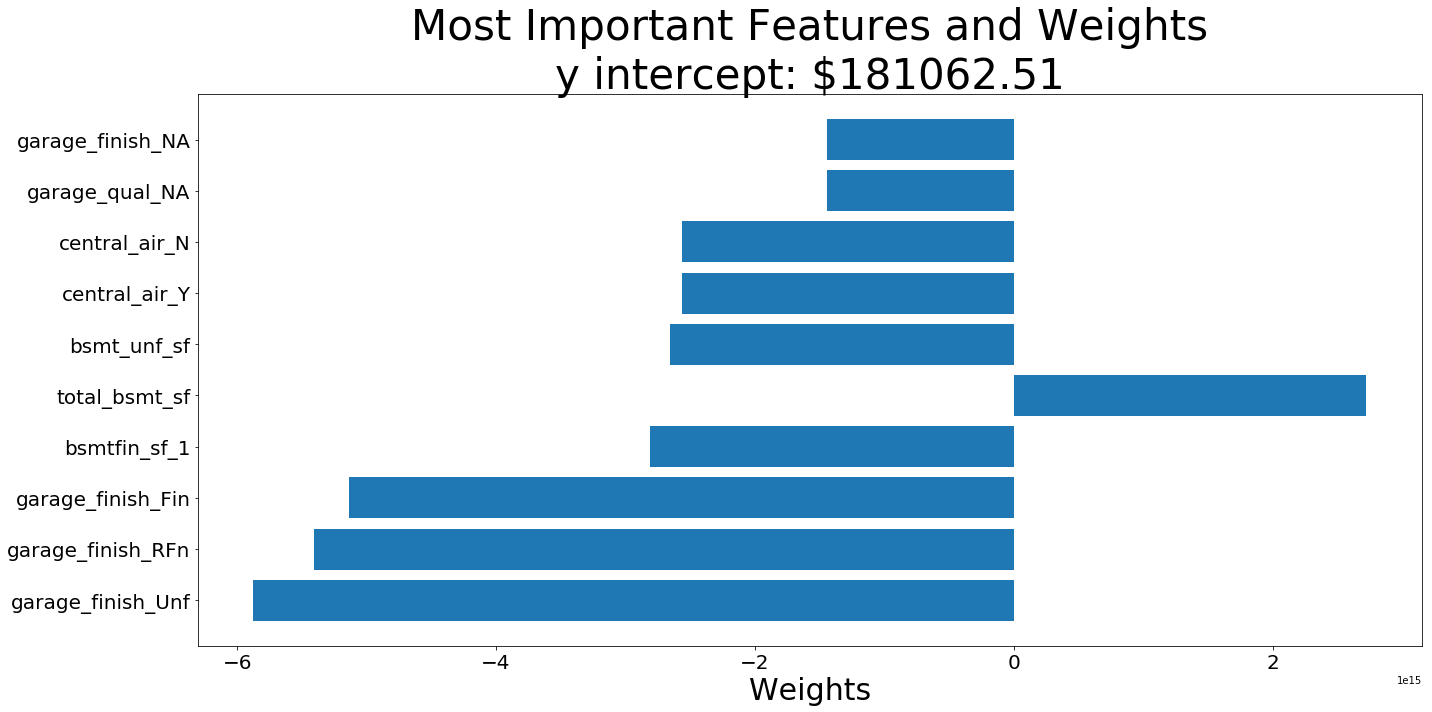

In [49]:
plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Weights', fontsize=30)
plt.title(f'Most Important Features and Weights\ny intercept: ${lr.intercept_:0.02f}', fontsize=42)
plt.tight_layout()

We see that interior finish of the garage has the greatest impact on sales. All of which have a negative relationship with the sales price.

These results are a bit nonsensical, and indicate that the linear regression model is not capturing the true relationship between the response and our predictors. We'll explore additinal linear models, such as the Ridge and the Lasso.

In [ ]:
with open('../assets/lin_reg.pkl', 'wb+') as f:
    pickle.dump(lr, f)